**Author:** Rocelle Nathalie Ong

# Problem Statement
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.  

Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics. 

# Objective
 
Our objective is to build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female.

# Dataset

The dataset contains eye pictures of males and females. The dataset contains the following:
* train - contains all the images that are to be used for training your model.
* Training_set.csv - this csv file has contains the labels for the training images
* test - contains 9000+ images. For these images you are required to make predictions
* Testing_set.csv - this is the order of the predictions for each image that is to be submitted on the platform.

# Solution

## Import packages and libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

import zipfile
import os
import pathlib
import glob
from pathlib import Path
import random

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import np_utils
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers

from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

## Prepare and Load the Dataset

In [2]:
input_folder = "../input/eye-gender-dataset/eye_gender_data"
print('Length of data images:' , len(list(pathlib.Path(input_folder).glob('*/*.jpg'))))

Length of data images: 11525


In [3]:
os.listdir(pathlib.Path(input_folder))

['sample_submission.csv',
 'Training_set.csv',
 'Testing_set.csv',
 'test',
 'train']

In [4]:
train_images = input_folder +'/train/'
print('Length of training data:' , len(glob.glob(train_images+'*.jpg')))

Length of training data: 9220


In [5]:
label = pd.read_csv(input_folder+'/Training_set.csv')
label.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


In [6]:
path = [[image_name, train_images + image_name] for image_name in label['filename']]
images = pd.DataFrame(path, columns=['filename', 'path'])
images.head()

,filename,path
0,Image_1.jpg,../input/eye-gender-dataset/eye_gender_data/tr...
1,Image_2.jpg,../input/eye-gender-dataset/eye_gender_data/tr...
2,Image_3.jpg,../input/eye-gender-dataset/eye_gender_data/tr...
3,Image_4.jpg,../input/eye-gender-dataset/eye_gender_data/tr...
4,Image_5.jpg,../input/eye-gender-dataset/eye_gender_data/tr...


In [7]:
df = pd.merge(images, label, how = 'inner', on = 'filename')
df.head()

,filename,path,label
0,Image_1.jpg,../input/eye-gender-dataset/eye_gender_data/tr...,male
1,Image_2.jpg,../input/eye-gender-dataset/eye_gender_data/tr...,female
2,Image_3.jpg,../input/eye-gender-dataset/eye_gender_data/tr...,female
3,Image_4.jpg,../input/eye-gender-dataset/eye_gender_data/tr...,female
4,Image_5.jpg,../input/eye-gender-dataset/eye_gender_data/tr...,male


In [8]:
df['path'][0]

'../input/eye-gender-dataset/eye_gender_data/train/Image_1.jpg'

## Exploratory Data Analysis

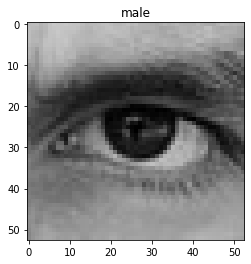

In [9]:
sample_image = plt.imread(df['path'][0])
plt.title(df['label'][0])
plt.imshow(sample_image)

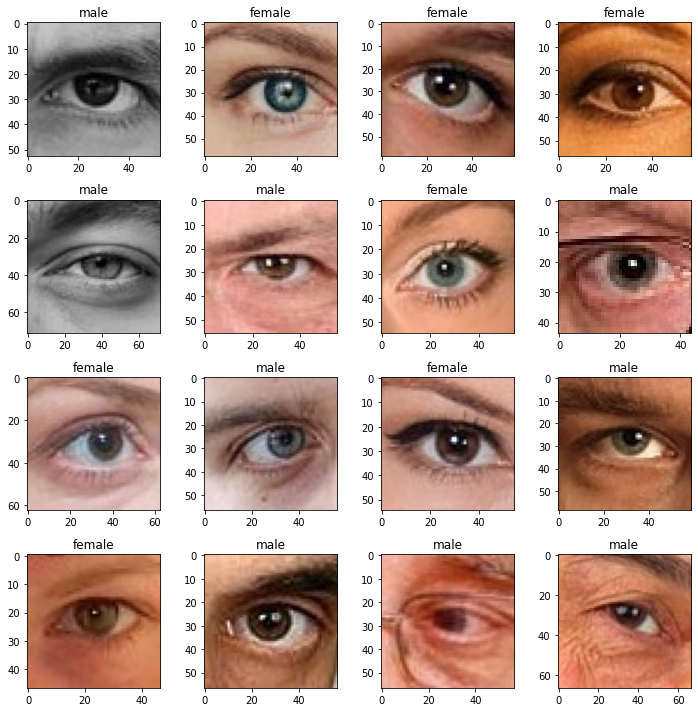

In [10]:
fig, axes = plt.subplots(nrows = 4,ncols = 4,figsize = (10, 10))

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["path"][i]))
    ax.set_title(df["label"][i])
plt.tight_layout()
plt.show()

In [11]:
sample_image.shape

(53, 53, 3)

In [12]:
df['label'].value_counts()

male      5058
female    4162
Name: label, dtype: int64

Text(0.5, 1.0, 'Distribution Count of Male and Female Eye Images')

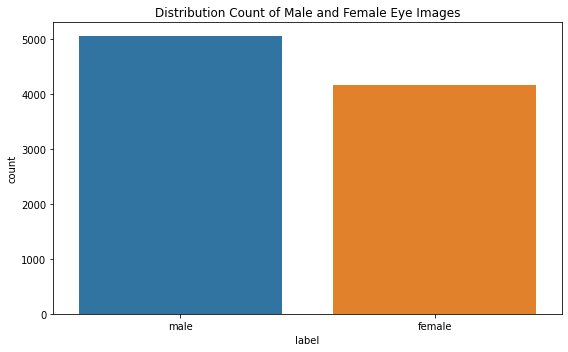

In [13]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True
sns.countplot(x=df['label'], data=df).set_title('Distribution Count of Male and Female Eye Images')

## Data Preprocessing

**Convert the label from categorical into numerical**

In [14]:
df['label'] = df['label'].replace({"male":0, "female":1})

**Convert the images into numpy array type**

In [15]:
data = []       
height, width = 100, 100

for i in range(len(df)):
  img = cv2.imread(df['path'][i])
  new_img = cv2.resize(img, (height, width))      
  data.append([new_img, df['label'][i]])

**Reshaping the images**

In [16]:
X, y = [], []
for i in data:
    img = i[0]/255
    img = img.reshape(100,100,3)
    label = i[1]

    X.append(img)
    y.append(label)

**Split X and y into train and test**

In [17]:
X = np.array(X)
y = np.array(y)

In [18]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

## Model Development

**Model 1:** Convolutional Neural Network

In [19]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
input_shape= (100,100,3)
batch_size = 32
epochs = 50

In [30]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape = input_shape, activation = 'relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 64)       

In [31]:
model.compile(optimizer='adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [32]:
model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[early_stop])

2022-11-09 01:17:21.879924: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 885120000 exceeds 10% of free system memory.


Epoch 1/50
231/231 [==============================] - 7s 25ms/step - loss: 0.5304 - accuracy: 0.7223 - val_loss: 0.5919 - val_accuracy: 0.7001
Epoch 2/50
231/231 [==============================] - 5s 21ms/step - loss: 0.3132 - accuracy: 0.8717 - val_loss: 0.2688 - val_accuracy: 0.8894
Epoch 3/50
231/231 [==============================] - 5s 21ms/step - loss: 0.2547 - accuracy: 0.8987 - val_loss: 0.2473 - val_accuracy: 0.8943
Epoch 4/50
231/231 [==============================] - 5s 21ms/step - loss: 0.2220 - accuracy: 0.9075 - val_loss: 0.2351 - val_accuracy: 0.9051
Epoch 5/50
231/231 [==============================] - 5s 21ms/step - loss: 0.1973 - accuracy: 0.9225 - val_loss: 0.2160 - val_accuracy: 0.9192
Epoch 6/50
231/231 [==============================] - 5s 21ms/step - loss: 0.1743 - accuracy: 0.9322 - val_loss: 0.1966 - val_accuracy: 0.9149
Epoch 7/50
231/231 [==============================] - 5s 21ms/step - loss: 0.1543 - accuracy: 0.9402 - val_loss: 0.2119 - val_accuracy: 0.9154

Text(0.5, 1.0, 'Training and Validation Accuracy')

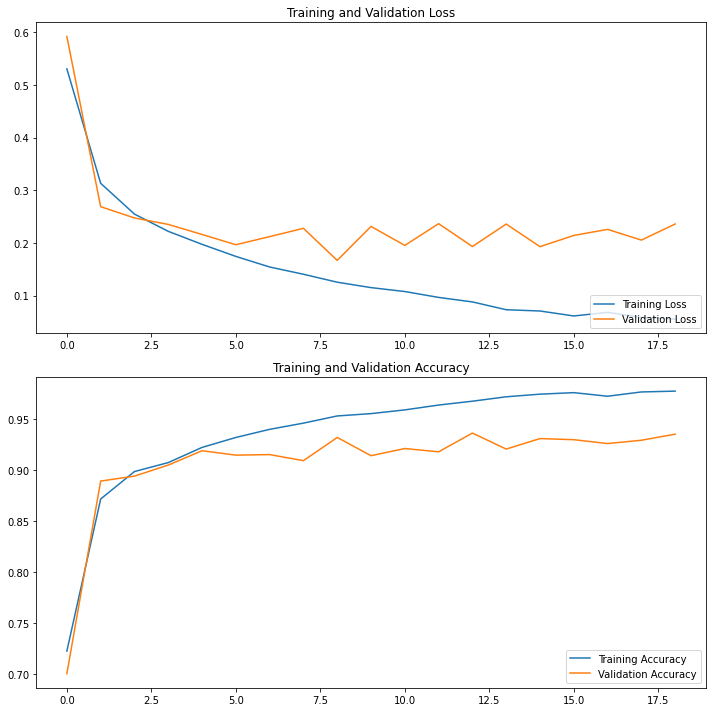

In [33]:
df_result = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result[['loss']], label='Training Loss')
plt.plot(df_result[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result[['accuracy']], label='Training Accuracy')
plt.plot(df_result[['val_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [34]:
# Overall Loss and Accuracy of the model
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss: {:.4f}".format(loss))

Training Accuracy: 0.9887
Training Loss: 0.0376
Testing Accuracy:  0.9355
Testing Loss: 0.2359


In [39]:
model_path = "./model1.h5"
model.save(model_path)

**Model 2:** VGG-16

In [40]:
vgg_layer = VGG16(input_shape = input_shape, include_top = False, weights = 'imagenet')
for layer in vgg_layer.layers:
    layer.trainable = False

In [61]:
model2 = Sequential()
model2.add(vgg_layer)
model2.add(Flatten())
model2.add(Dense(units = 512, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1024, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

In [63]:
model2.compile(optimizer='adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [64]:
model2.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val,y_val), callbacks=[early_stop])

Epoch 1/50
231/231 [==============================] - 11s 44ms/step - loss: 0.3976 - accuracy: 0.8186 - val_loss: 0.2682 - val_accuracy: 0.8915
Epoch 2/50
231/231 [==============================] - 10s 42ms/step - loss: 0.2561 - accuracy: 0.8929 - val_loss: 0.2329 - val_accuracy: 0.9008
Epoch 3/50
231/231 [==============================] - 10s 43ms/step - loss: 0.2269 - accuracy: 0.9036 - val_loss: 0.2313 - val_accuracy: 0.9046
Epoch 4/50
231/231 [==============================] - 10s 44ms/step - loss: 0.2028 - accuracy: 0.9158 - val_loss: 0.2249 - val_accuracy: 0.9024
Epoch 5/50
231/231 [==============================] - 10s 43ms/step - loss: 0.2091 - accuracy: 0.9139 - val_loss: 0.2023 - val_accuracy: 0.9138
Epoch 6/50
231/231 [==============================] - 10s 42ms/step - loss: 0.1811 - accuracy: 0.9257 - val_loss: 0.2432 - val_accuracy: 0.8959
Epoch 7/50
231/231 [==============================] - 10s 42ms/step - loss: 0.1883 - accuracy: 0.9178 - val_loss: 0.2083 - val_accuracy:

Text(0.5, 1.0, 'Training and Validation Accuracy')

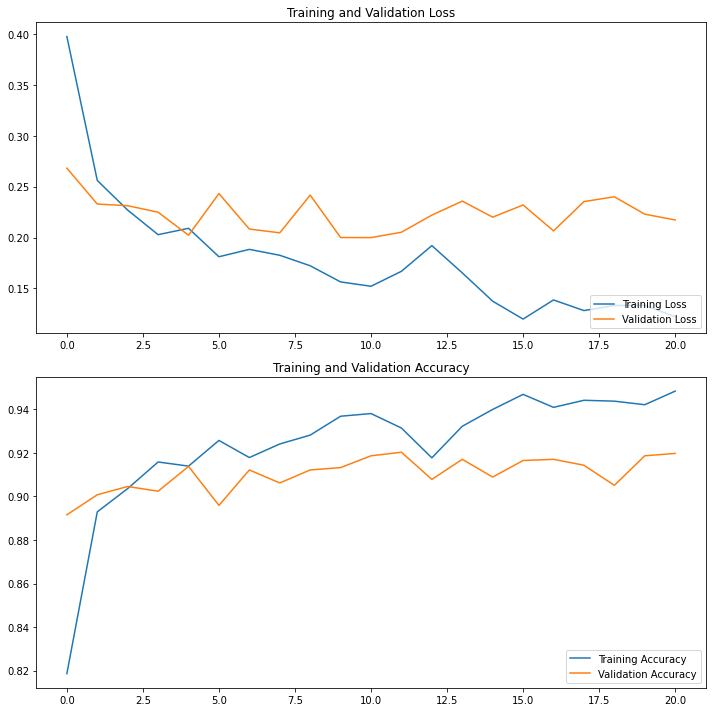

In [65]:
df_result = pd.DataFrame(model2.history.history)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(df_result[['loss']], label='Training Loss')
plt.plot(df_result[['val_loss']], label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(df_result[['accuracy']], label='Training Accuracy')
plt.plot(df_result[['val_accuracy']], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [66]:
# Overall Loss and Accuracy of the model
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
loss, accuracy = model2.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss: {:.4f}".format(loss))

Training Accuracy: 0.9717
Training Loss: 0.0828
Testing Accuracy:  0.9197
Testing Loss: 0.2173


In [46]:
model_path = "./model2.h5"
model2.save(model_path)

## Model Evaluation

In [35]:
test_images = input_folder +'/test/'
test_df = pd.read_csv(input_folder+'/Testing_set.csv')
test_df.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [36]:
test = []
for i in test_df['filename']:
  img = cv2.imread(test_images + i)
  img = cv2.resize(img, (height, width))
  test.append(img)

test = np.array(test)

In [72]:
predictions = model.predict(test)
prediction = []
for i in range(0,len(predictions)):
    if predictions[i]<=0.5:
        out=0
    else:
        out=1
    prediction.append(out)
    
predictions_df=pd.DataFrame(prediction,columns=['label'])
predictions_df['label'].replace([0,1],['male','female'],inplace=True)
predictions_df.to_csv("submission.csv", index = False)

In [73]:
predictions_df_covnet

,label
0,male
1,female
2,female
3,male
4,female
...,...
2300,female
2301,female
2302,male
2303,male


In [70]:
predictions = model2.predict(test)
prediction = []
for i in range(0,len(predictions)):
    if predictions[i]<=0.5:
        out=0
    else:
        out=1
    prediction.append(out)
    
predictions_df_vgg=pd.DataFrame(prediction,columns=['label'])
predictions_df_vgg['label'].replace([0,1],['male','female'],inplace=True)
predictions_df_vgg.to_csv("submission.csv", index = False)

In [71]:
predictions_df_vgg

,label
0,male
1,male
2,male
3,male
4,female
...,...
2300,female
2301,female
2302,male
2303,male
